In [21]:
import os
from recordtype import recordtype
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import tensorflow as tf

import pofah.jet_sample as jesa
import dadrah.util.run_paths as runpa
import dadrah.selection.anomaly_score_strategy as ansc
import dadrah.util.string_constants as stco
import dadrah.util.logging as log

In [22]:
def normalize_data(x_train):
    mu = np.mean(x_train)
    std = np.std(x_train)
    def normalize(x):
        return (x-mu)/std
    return normalize

In [23]:
def min_max_normalize_data(x_train):
    min_x = np.min(x_train)
    max_x = np.max(x_train)
    def normalize(x):
        return (x-min_x)/(max_x-min_x)
    return normalize

In [24]:
def plot_data(x_train, x_test, y_train, y_test, plot_suffix='', fig_dir='fig'):

    fig, axs = plt.subplots(1,2,figsize=(8,4))
    
    ax_x, ax_y = axs.flat
    
    bins, lw = 70, 1.6
    density = False

    ax_x.hist(x_train, bins=bins, density=density, histtype='step', label='x train', lw=lw)
    ax_x.hist(x_test, bins=bins, density=density, histtype='step', label='x test', lw=lw)
    ax_y.hist(y_train, bins=bins, density=density, histtype='step', label='y train', lw=lw)
    ax_y.hist(y_test, bins=bins, density=density, histtype='step', label='y test', lw=lw)

    ax_x.set_xlabel('mJJ')
    ax_y.set_xlabel('anomaly score')
    ax_x.set_yscale('log')
    ax_y.set_yscale('log')
    
    ax_x.legend()
    ax_y.legend()
    plt.show()
    plt.savefig(os.path.join(fig_dir,'x_y_distributions'+plot_suffix+'.png'))

In [25]:
train_split = 0.3

Parameters = recordtype('Parameters','vae_run_n, qr_run_n, qcd_train_sample_id, qcd_test_sample_id, sig_sample_id, strategy_id, epochs, read_n, qr_model_t')
params = Parameters(
                vae_run_n=113,
                qr_run_n=111,
                qcd_train_sample_id='qcdSigAllTrain'+str(int(train_split*100))+'pct', 
                qcd_test_sample_id='qcdSigAllTest'+str(int((1-train_split)*100))+'pct',
                sig_sample_id='GtoWW35naReco',
                strategy_id='rk5_05',
                epochs=100,
                read_n=None, #int(1e6),
                qr_model_t=stco.QR_Model.DENSE,
                )
fig_dir = '../fig/sample_analysis'

In [26]:
sig_xsec = 0.
in_train_path_ext_dict = {'run': str(params.vae_run_n), 'qcd_sqrtshatTeV_13TeV_PU40_NEW_ALL_Train_signalregion_parts': None}
in_test_path_ext_dict = {'run': str(params.vae_run_n), 'qcd_sqrtshatTeV_13TeV_PU40_NEW_ALL_Test_signalregion_parts': None}

### paths ###

# data inputs (mjj & vae-scores): /eos/user/k/kiwoznia/data/VAE_results/events/run_$vae_run_n$
# model outputs: /eos/home-k/kiwoznia/data/QR_models/vae_run_$run_n_vae$/qr_run_$run_n_qr$
# data outputs (selections [0/1] per quantile): /eos/user/k/kiwoznia/data/QR_results/events/

paths_train = runpa.RunPaths(in_data_dir=stco.dir_path_dict['base_dir_vae_results_qcd_train'], in_data_names=stco.file_name_path_dict, out_data_dir=stco.dir_path_dict['base_dir_qr_selections'])
paths_train.extend_in_path_data(in_train_path_ext_dict)
paths_test = runpa.RunPaths(in_data_dir=stco.dir_path_dict['base_dir_vae_results_qcd_train'], in_data_names=stco.file_name_path_dict, out_data_dir=stco.dir_path_dict['base_dir_qr_selections'])
paths_test.extend_in_path_data(in_test_path_ext_dict)


In [27]:
#****************************************#
#           read in qcd data
#****************************************#

qcd_train_sample = jesa.JetSample.from_input_file(params.qcd_train_sample_id, paths_train.in_file_path(params.qcd_train_sample_id), read_n=params.read_n) 
qcd_test_sample = jesa.JetSample.from_input_file(params.qcd_test_sample_id, paths_test.in_file_path(params.qcd_test_sample_id), read_n=params.read_n)
print('read {} train samples from {}'.format(len(qcd_train_sample),paths_train.in_file_path(params.qcd_train_sample_id)))
print('read {} test samples from {} '.format(len(qcd_test_sample),paths_test.in_file_path(params.qcd_test_sample_id)))

read 2876909 train samples from /eos/user/k/kiwoznia/data/VAE_results/events/run_113/qcd_sqrtshatTeV_13TeV_PU40_NEW_ALL_Train_signalregion_parts/qcd_sqrtshatTeV_13TeV_PU40_NEW_ALL_Train_30.h5
read 6712789 test samples from /eos/user/k/kiwoznia/data/VAE_results/events/run_113/qcd_sqrtshatTeV_13TeV_PU40_NEW_ALL_Test_signalregion_parts/qcd_sqrtshatTeV_13TeV_PU40_NEW_ALL_Test_70.h5 


In [28]:
#****************************************#
#           prepare inputs & targets
#****************************************#
score_strategy = ansc.an_score_strategy_dict[params.strategy_id]
x_train, x_test = qcd_train_sample['mJJ'], qcd_test_sample['mJJ']
y_train, y_test = score_strategy(qcd_train_sample), score_strategy(qcd_test_sample) 

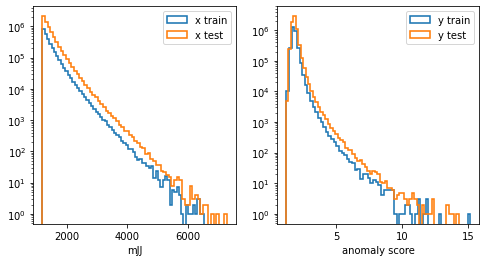

<Figure size 432x288 with 0 Axes>

In [29]:
plot_data(x_train, x_test, y_train, y_test, fig_dir=fig_dir)

In [30]:
sum(x_train > 4000.)

872

In [31]:
# set up std normalizations
norm_x_std = preprocessing.StandardScaler()
norm_y_std = preprocessing.StandardScaler()

x_train_std, x_test_std = norm_x_std.fit_transform(x_train.reshape(-1,1)).squeeze(), norm_x_std.transform(x_test.reshape(-1,1)).squeeze()
y_train_std, y_test_std = norm_y_std.fit_transform(y_train.reshape(-1,1)).squeeze(), norm_y_std.transform(y_test.reshape(-1,1)).squeeze()

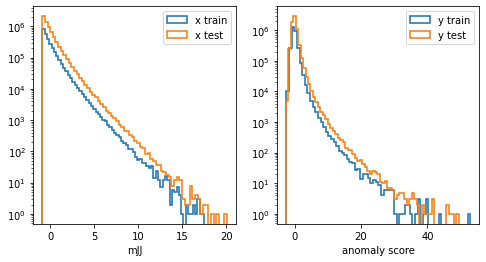

<Figure size 432x288 with 0 Axes>

In [32]:
plot_data(x_train_std, x_test_std, y_train_std, y_test_std, plot_suffix='std_normed', fig_dir=fig_dir)

In [33]:
# set up min max normalizations
norm_x_mima = preprocessing.MinMaxScaler()
norm_y_mima = preprocessing.MinMaxScaler()

x_train_mima, x_test_mima = norm_x_mima.fit_transform(x_train.reshape(-1,1)).squeeze(), norm_x_mima.transform(x_test.reshape(-1,1)).squeeze()
y_train_mima, y_test_mima = norm_y_mima.fit_transform(y_train.reshape(-1,1)).squeeze(), norm_y_mima.transform(y_test.reshape(-1,1)).squeeze()

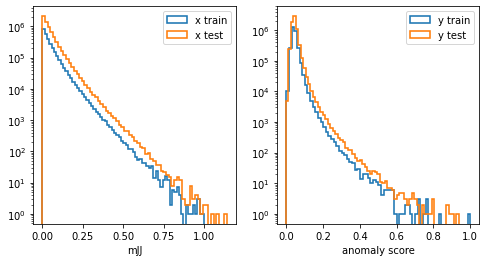

<Figure size 432x288 with 0 Axes>

In [34]:
plot_data(x_train_mima, x_test_mima, y_train_mima, y_test_mima, plot_suffix='minmax_normed', fig_dir=fig_dir)

In [35]:
tr4k = norm_x_mima.transform([[4000.]])[0][0]

In [36]:
tr4k

0.5238144141621888

In [38]:
sum(x_train_mima > tr4k)

872

# analyzing batched tf dataset

In [42]:
train_dataset = tf.data.Dataset.from_tensor_slices(x_train_mima)

In [43]:
sum(list(train_dataset.as_numpy_iterator())>tr4k)

872

In [40]:
for x,y in train_dataset.take(5).as_numpy_iterator():
    print(x,y)

0.023366332 0.019639984
0.0076019466 0.03586421
0.040346026 0.039125107
0.07945734 0.06852854
0.0073760003 0.045391805
